## Paquetes

#### NPS actualizado cada fila nueva N

In [100]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
import random
import pickle
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist


import warnings
warnings.filterwarnings('ignore')
seed = 2020
random.seed(seed)

## Datos

In [101]:
#os.listdir()

In [102]:
df_wsp=pd.read_csv('Whatsapp.csv', sep=';')
df_tlg=pd.read_csv('Telegram.csv', sep=';')
df_sgl=pd.read_csv('Signal.csv', sep=';')

In [103]:
df_wsp.shape , df_tlg.shape , df_sgl.shape

((6085, 9), (4920, 9), (3778, 9))

In [104]:
df_wsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6085 entries, 0 to 6084
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6085 non-null   object
 1   score         6085 non-null   int64 
 2   id            6085 non-null   object
 3   subreddit     6085 non-null   object
 4   url           6085 non-null   object
 5   num_comments  6085 non-null   int64 
 6   body          3881 non-null   object
 7   created       6085 non-null   object
 8   comments      2573 non-null   object
dtypes: int64(2), object(7)
memory usage: 428.0+ KB


### Nulos en el Dataset


In [105]:
df_wsp.isnull().sum()

title              0
score              0
id                 0
subreddit          0
url                0
num_comments       0
body            2204
created            0
comments        3512
dtype: int64

In [106]:
df_tlg.isnull().sum()

title              0
score              0
id                 0
subreddit          0
url                0
num_comments       0
body             783
created            0
comments        2733
dtype: int64

In [107]:
df_sgl.isnull().sum()

title             0
score             0
id                0
subreddit         0
url               0
num_comments      0
body            568
created           0
comments        544
dtype: int64

## Eliminando Nulos

In [108]:
df_wsp=df_wsp[df_wsp.body.notna()]
df_tlg=df_tlg[df_tlg.body.notna()]
df_sgl=df_sgl[df_sgl.body.notna()]

In [109]:
df_wsp.fillna("",inplace =True)
df_tlg.fillna("",inplace =True)
df_sgl.fillna("",inplace =True)

In [110]:
df_wsp.shape , df_tlg.shape , df_sgl.shape

((3881, 9), (4137, 9), (3210, 9))

## Data Cleaning

In [111]:
nltk.download('stopwords')

ls_stopwords = stopwords.words('english')
lm = WordNetLemmatizer()

def text_prep(text:str):
    tokens = []
    for w in word_tokenize(text):
        w = w.lower()
        if ((w.isalpha()) and (w not in ls_stopwords)): tokens.append(lm.lemmatize(w))
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FRANK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
nltk.download('punkt')
nltk.download('wordnet')

df_wsp["body"]=df_wsp.body.apply(text_prep)
df_wsp["comments"]=df_wsp.comments.apply(text_prep)
df_wsp.query("body !='deleted' and body !='removed' ", inplace=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FRANK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FRANK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [113]:
df_tlg["body"]=df_tlg.body.apply(text_prep)
df_tlg["comments"]=df_tlg.comments.apply(text_prep)
df_tlg.query("body !='deleted' and body !='removed' ", inplace=True)

In [114]:
df_sgl["body"]=df_sgl.body.apply(text_prep)
df_sgl["comments"]=df_sgl.comments.apply(text_prep)
df_sgl.query("body !='deleted' and body !='removed' ", inplace=True)

In [115]:
df_wsp.shape , df_tlg.shape , df_sgl.shape

((2384, 9), (1135, 9), (2278, 9))

In [116]:
#data sample
df_wsp.head()

,title,score,id,subreddit,url,num_comments,body,created,comments
0,"German Stickers ""1Typ"" from Fehlgeburt",1,l6feyk,whatsapp,https://www.reddit.com/r/whatsapp/comments/l6f...,0,http http today new stickerapp got released ne...,2021-01-28 00:53:51,
1,What did WhatsApp update this time?,1,l6egin,whatsapp,https://www.reddit.com/r/whatsapp/comments/l6e...,1,heard many people saying whatsapp updated chan...,2021-01-28 00:09:03,whatsapp remains end end encrypted read messag...
6,QR scanner not working,1,l6al8f,whatsapp,https://www.reddit.com/r/whatsapp/comments/l6a...,0,try scan code message keep popping want whatsa...,2021-01-27 21:04:45,
8,"Sorry, this media file appears to be missing.",1,l5hd0z,whatsapp,https://www.reddit.com/r/whatsapp/comments/l5h...,2,currently trying download pdf view pdf viewer ...,2021-01-26 19:21:41,file removed wa server unless download ca down...
9,Where is the chat background stored?,1,l5gyss,whatsapp,https://www.reddit.com/r/whatsapp/comments/l5g...,2,hi like recover chat background image longer g...,2021-01-26 19:03:23,yes ok u tell


### Polaridad y NPS por sub corpus textual 


#### 1. Importamos librerías esenciales

In [117]:
import scipy.stats as ss
from nltk import tokenize
from statistics import mean
from textblob import TextBlob #polarity and subjectivity
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [118]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\FRANK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [119]:
def getPolarity(text):
    return sid.polarity_scores(text)["compound"]

#### 2. Calculamos polaridad ('TextBlob method')

In [120]:
#adding polarity for main text body ('B')
df_wsp["polarityB"] = df_wsp.body.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)

df_tlg["polarityB"] = df_tlg.body.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)
df_sgl["polarityB"] = df_sgl.body.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)

In [121]:
#adding polarity for comments ('C')
df_wsp["polarityC"] = df_wsp.comments.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)
df_tlg["polarityC"] = df_tlg.comments.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)
df_sgl["polarityC"] = df_sgl.comments.apply(
    lambda text_comment: pd.Series(getPolarity(text_comment))
)

In [122]:
#dropping when body polarity is different from zero (useful only)
df_wsp = df_wsp.query("polarityB !=0")
df_tlg = df_tlg.query("polarityB !=0")
df_sgl = df_sgl.query("polarityB !=0")

In [123]:
#dropping when comments polarity is different from zero (useful only)
df_wsp = df_wsp.query("polarityC !=0")
df_tlg = df_tlg.query("polarityC !=0")
df_sgl = df_sgl.query("polarityC !=0")

In [124]:
#invert the order of rows from oldest-newest
df_wsp, df_tlg, df_sgl = df_wsp.iloc[::-1], df_tlg.iloc[::-1], df_sgl.iloc[::-1]

In [125]:
#string time transformation to datetime format
df_wsp["created"]=pd.to_datetime(df_wsp.created)
df_tlg["created"]=pd.to_datetime(df_tlg.created)
df_sgl["created"]=pd.to_datetime(df_sgl.created)

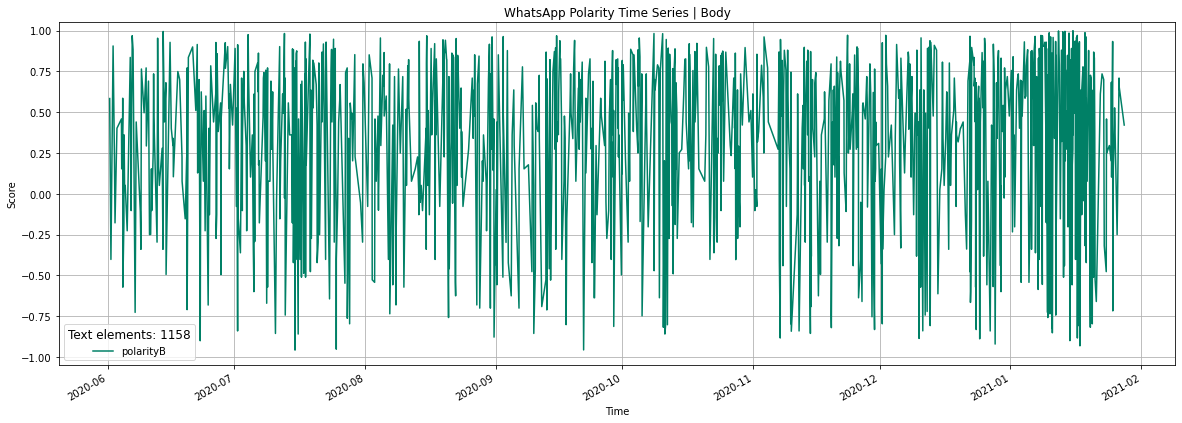

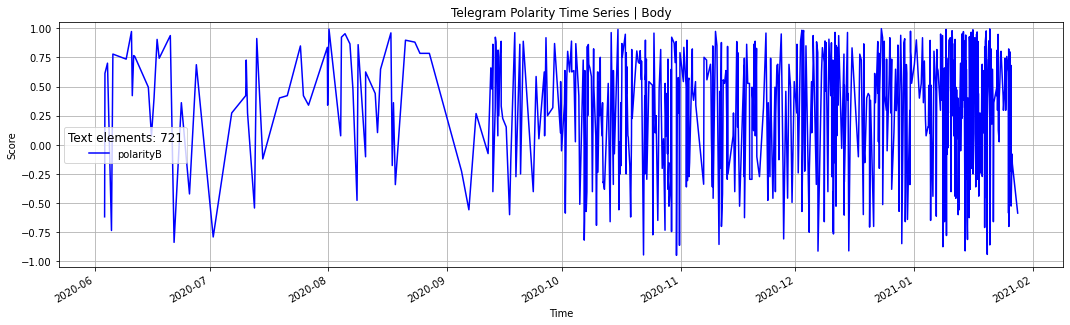

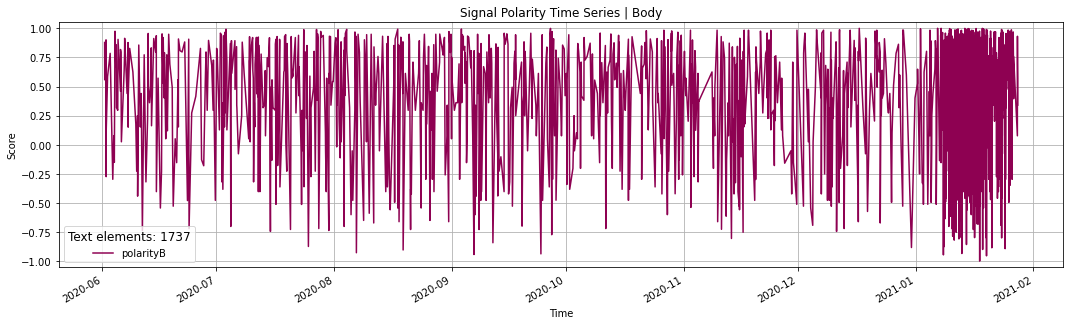

In [126]:
#plot polarity of body
df_wsp[["created", "polarityB"]].set_index('created').plot(
    figsize=(20,7), grid=True, colormap='summer', 
).set(xlabel="Time", ylabel="Score", 
      title='WhatsApp Polarity Time Series | Body', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_wsp.shape[0]}", prop={'size':'large'}
)
plt.show()

df_tlg[["created", "polarityB"]].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='winter'
).set(xlabel="Time", ylabel="Score", 
      title='Telegram Polarity Time Series | Body', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_tlg.shape[0]}", prop={'size':'large'}
)
plt.show()


df_sgl[["created", "polarityB"]].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='PiYG'
).set(xlabel="Time", ylabel="Score",
     title='Signal Polarity Time Series | Body', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_sgl.shape[0]}", prop={'size':'large'}
)
plt.show()

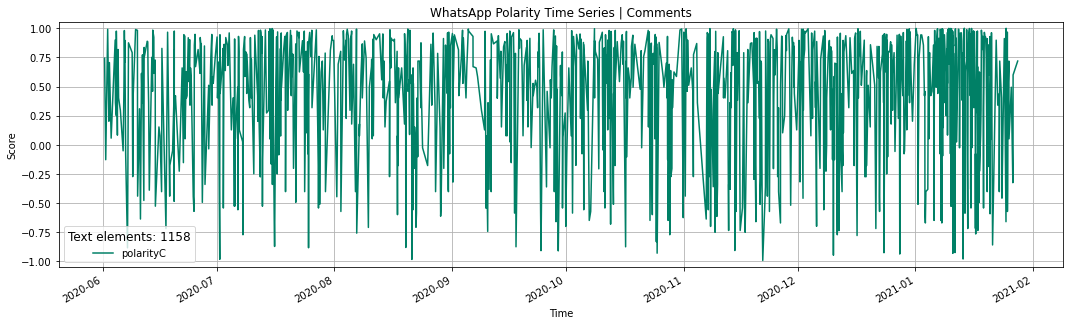

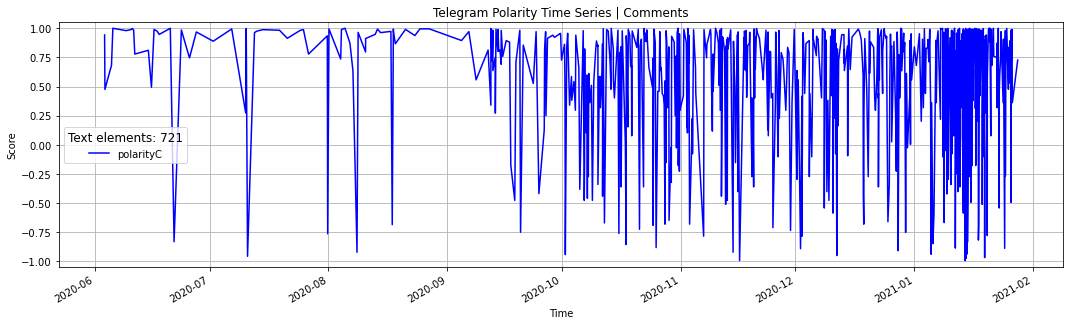

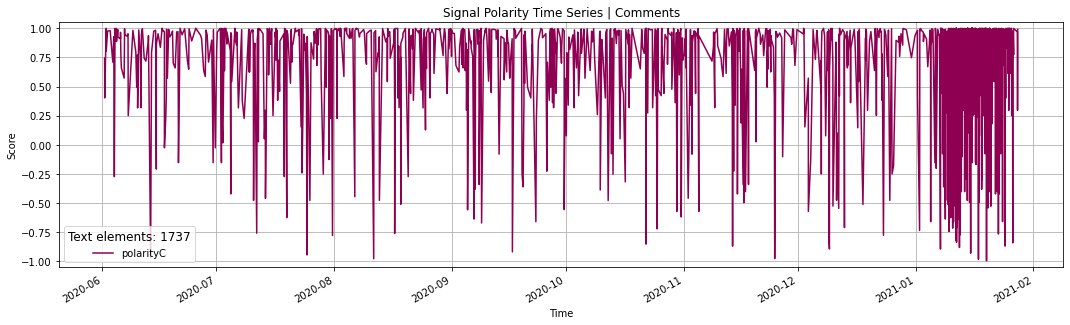

In [127]:
#plot polarity of comments
df_wsp[["created", "polarityC"]].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='summer', 
).set(xlabel="Time", ylabel="Score", 
      title='WhatsApp Polarity Time Series | Comments', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_wsp.shape[0]}", prop = {'size':'large'}
)
plt.show()

df_tlg[["created", "polarityC"]].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='winter'
).set(xlabel="Time", ylabel="Score", 
      title='Telegram Polarity Time Series | Comments', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_tlg.shape[0]}", prop={'size':'large'}
)
plt.show()

df_sgl[["created", "polarityC"]].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='PiYG'
).set(xlabel="Time", ylabel="Score",
     title='Signal Polarity Time Series | Comments', ylim=(-1.05,1.05)
     )
plt.legend().set_title(
    title=f"Text elements: {df_sgl.shape[0]}", prop={'size':'large'}
)
plt.show()

In [128]:
#grouping polarity by timeframeworks

#WhatsApp
politicas_time_date = "2020-12-02"
limit_politicas_time_date = "2021-01-02"

pre_politicas_wsp = df_wsp.loc[
    df_wsp["created"] < politicas_time_date
]
in_politicas_wsp = df_wsp.loc[
    (politicas_time_date <= df_wsp["created"]) & 
    (df_wsp["created"] <= limit_politicas_time_date)
]
post_politicas_wsp = df_wsp.loc[
    limit_politicas_time_date < df_wsp["created"] 
]
total_wsp = (
    post_politicas_wsp.shape[0] + 
    in_politicas_wsp.shape[0] + 
    pre_politicas_wsp.shape[0]
)

#Telegram
pre_politicas_tlg = df_tlg.loc[
    df_tlg["created"] < politicas_time_date
]
in_politicas_tlg = df_tlg.loc[
    (politicas_time_date <= df_tlg["created"]) & 
    (df_tlg["created"] <= limit_politicas_time_date)
]
post_politicas_tlg = df_tlg.loc[
    limit_politicas_time_date < df_tlg["created"] 
]

total_tlg = (
    post_politicas_tlg.shape[0] + 
    in_politicas_tlg.shape[0] + 
    pre_politicas_tlg.shape[0]
)

#Signal
pre_politicas_sgl = df_sgl.loc[
    df_sgl["created"] < politicas_time_date
]
in_politicas_sgl = df_sgl.loc[
    (politicas_time_date <= df_sgl["created"]) & 
    (df_sgl["created"] <= limit_politicas_time_date)
]
post_politicas_sgl = df_sgl.loc[
    limit_politicas_time_date < df_sgl["created"] 
]

total_sgl = (
    post_politicas_sgl.shape[0] + 
    in_politicas_sgl.shape[0] + 
    pre_politicas_sgl.shape[0]
)


print("Reporte de datos por Horizonte Temporal: ")
print("--"*20)
print("WhatsApp:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {pre_politicas_wsp.shape[0]}")
print(f"- Etapa 'In Políticas'   | Total: {in_politicas_wsp.shape[0]}")
print(f"- Etapa 'Post Políticas' | Total: {post_politicas_wsp.shape[0]}")
print(f"     Elementos textuales totales: {total_wsp}\n")
print("Telegram:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {pre_politicas_tlg.shape[0]}")
print(f"- Etapa 'In Políticas'   | Total: {in_politicas_tlg.shape[0]}")
print(f"- Etapa 'Post Políticas' | Total: {post_politicas_tlg.shape[0]}")
print(f"     Elementos textuales totales: {total_tlg}\n")
print("Signal:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {pre_politicas_sgl.shape[0]}")
print(f"- Etapa 'In Políticas'   | Total: {in_politicas_sgl.shape[0]}")
print(f"- Etapa 'Post Políticas' | Total: {post_politicas_sgl.shape[0]}")
print(f"     Elementos textuales totales: {total_sgl}\n")

Reporte de datos por Horizonte Temporal: 
----------------------------------------
WhatsApp:

- Etapa 'Pre Políticas'  | Total: 788
- Etapa 'In Políticas'   | Total: 158
- Etapa 'Post Políticas' | Total: 212
     Elementos textuales totales: 1158

Telegram:

- Etapa 'Pre Políticas'  | Total: 344
- Etapa 'In Políticas'   | Total: 129
- Etapa 'Post Políticas' | Total: 248
     Elementos textuales totales: 721

Signal:

- Etapa 'Pre Políticas'  | Total: 741
- Etapa 'In Políticas'   | Total: 115
- Etapa 'Post Políticas' | Total: 881
     Elementos textuales totales: 1737



In [129]:
#creating new "politica" category 
pre_politicas_wsp["Etapa"] = "pre_politica"
in_politicas_wsp["Etapa"] = "in_politica"
post_politicas_wsp["Etapa"] = "post_politica"

pre_politicas_tlg["Etapa"] = "pre_politica"
in_politicas_tlg["Etapa"] = "in_politica"
post_politicas_tlg["Etapa"] = "post_politica"

pre_politicas_sgl["Etapa"] = "pre_politica"
in_politicas_sgl["Etapa"] = "in_politica"
post_politicas_sgl["Etapa"] = "post_politica"

df_wsp_new = pd.concat(
    [pre_politicas_wsp, in_politicas_wsp, post_politicas_wsp]
)
df_tlg_new = pd.concat(
    [pre_politicas_tlg, in_politicas_tlg, post_politicas_tlg]
)
df_sgl_new = pd.concat(
    [pre_politicas_sgl, in_politicas_sgl, post_politicas_sgl]
)

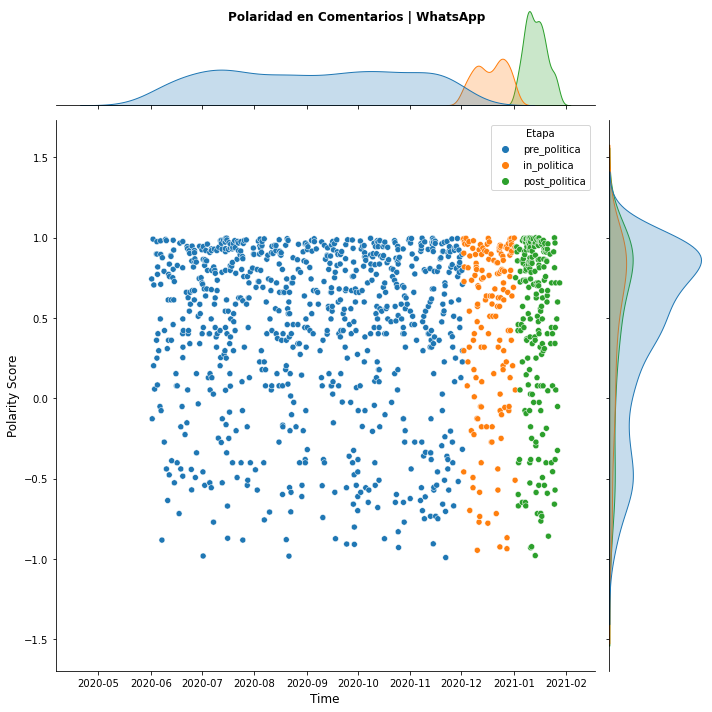

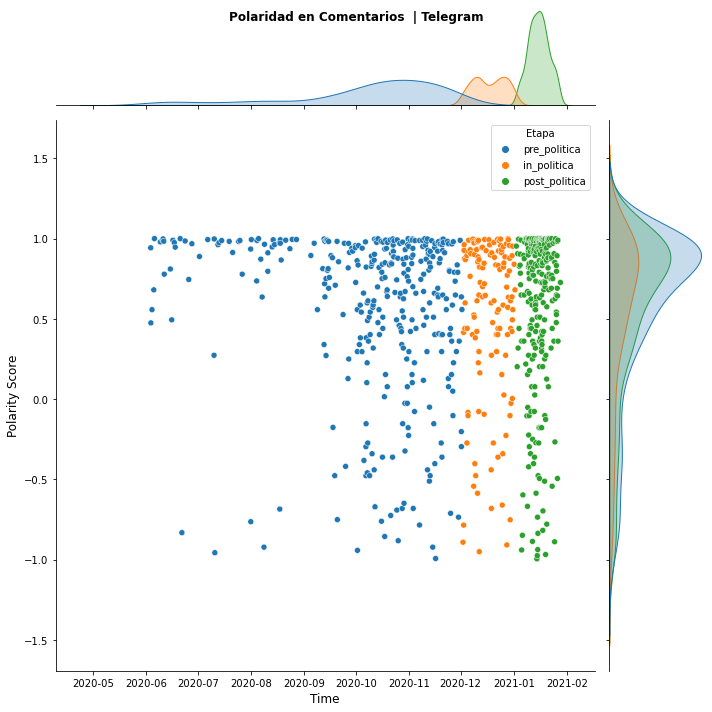

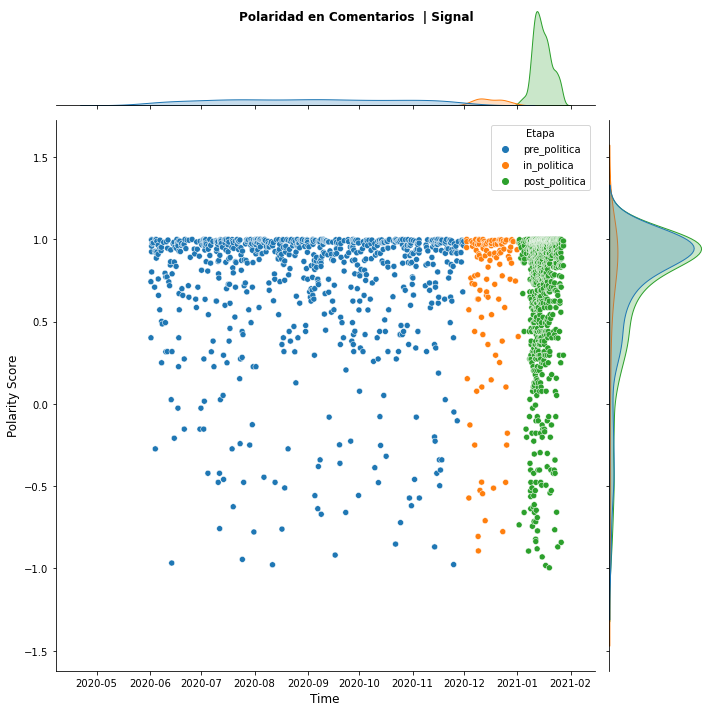

In [130]:
#WhatsApp Plot
ax = sns.jointplot(data=df_wsp_new, x="created", y="polarityC", hue='Etapa', height=10)
ax.fig.suptitle(
    'Polaridad en Comentarios | WhatsApp', 
    fontsize=12, fontweight='bold'
)
ax.set_axis_labels('Time', 'Polarity Score', fontsize=12)
plt.tight_layout()

#Telegram Plot
ax = sns.jointplot(data=df_tlg_new, x="created", y="polarityC", hue='Etapa', height=10)
ax.fig.suptitle(
    'Polaridad en Comentarios  | Telegram', 
    fontsize=12, fontweight='bold'
)
ax.set_axis_labels('Time', 'Polarity Score', fontsize=12)
plt.tight_layout()

#Telegram Plot
ax = sns.jointplot(data=df_sgl_new, x="created", y="polarityC", hue='Etapa', height=10)
ax.fig.suptitle(
    'Polaridad en Comentarios  | Signal', 
    fontsize=12, fontweight='bold'
)
ax.set_axis_labels('Time', 'Polarity Score', fontsize=12)
plt.tight_layout()

In [131]:
#rescaling base statement setting for range 0-10 to find "NP Value"
scaler = MinMaxScaler(feature_range=(0,10))

In [132]:
#Whatsapp NP Value 
scaler.fit(df_wsp_new.polarityC.values.reshape(-1,1))
df_wsp_new["npvalue"] = np.round(
    scaler.transform(df_wsp_new.polarityC.values.reshape(-1,1))
)

In [133]:
#Telegram NP Value
scaler.fit(df_tlg_new.polarityC.values.reshape(-1,1))
df_tlg_new["npvalue"] = np.round(
    scaler.transform(df_tlg_new.polarityC.values.reshape(-1,1)
                    )
)

In [134]:
#Signal NP Value
scaler.fit(df_sgl_new.polarityC.values.reshape(-1,1))
df_sgl_new["npvalue"] = np.round(
    scaler.transform(df_sgl_new.polarityC.values.reshape(-1,1))
)

In [135]:
#adding "NP Category" | WhatsApp
df_wsp_new["npcategory"] = df_wsp_new.npvalue.apply(
    lambda x: "Promotor" if x >= 9 else ("Pasivo" if 7 <= x < 9 else "Detractor")
)

#adding "NP Category" | Telegram
df_tlg_new["npcategory"] = df_tlg_new.npvalue.apply(
    lambda x: "Promotor" if x >= 9 else ("Pasivo" if 7 <= x < 9 else "Detractor")
)

#Adding "NP Category" | Signal
df_sgl_new["npcategory"] = df_sgl_new.npvalue.apply(
    lambda x: "Promotor" if x >= 9 else ("Pasivo" if 7 <= x < 9 else "Detractor")
)

In [136]:
df_wsp_new

,title,score,id,subreddit,url,num_comments,body,created,comments,polarityB,polarityC,Etapa,npvalue,npcategory
6080,Got a weird whatsapp video call,5,gug0e8,whatsapp,https://www.reddit.com/r/whatsapp/comments/gug...,2,repeatedly got video call whatsapp boyfriend r...,2020-06-01 10:23:01,sound like someone else access account contact...,0.5839,0.7430,pre_politica,9.0,Promotor
6074,Is there another way to connect to WA web?,4,gulmh7,whatsapp,https://www.reddit.com/r/whatsapp/comments/gul...,3,trouble camera ca scan de qr code whatsapp web...,2020-06-01 17:29:51,dont know possible installed app use phone cam...,-0.4019,-0.1280,pre_politica,4.0,Detractor
6063,Security Question - New Number,4,guz0iq,whatsapp,https://www.reddit.com/r/whatsapp/comments/guz...,12,hi change number due security concern someone ...,2020-06-02 05:48:24,need set new account deactivate account mean e...,0.9062,0.9909,pre_politica,10.0,Promotor
6061,How to select the contacts to import to WhatsA...,5,gv4u62,whatsapp,https://www.reddit.com/r/whatsapp/comments/gv4...,1,want import customer contact personal whatsapp...,2020-06-02 13:27:00,list would like hide contact conversation list...,0.2263,0.2023,pre_politica,6.0,Detractor
6058,Hide online status,3,gv7mtv,whatsapp,https://www.reddit.com/r/whatsapp/comments/gv7...,3,feature hide online status people similar stat...,2020-06-02 16:47:05,would indeed nice however whatsapp slow add fe...,-0.1779,0.7055,pre_politica,9.0,Promotor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Accidentally sent a photo to two chats,0,l56cti,whatsapp,https://www.reddit.com/r/whatsapp/comments/l56...,1,accidentally sent photo two separate chat conv...,2021-01-26 07:40:01,seems pretty obvious message conversation grou...,-0.2500,0.4939,post_politica,7.0,Pasivo
15,Favourited stickers gone,1,l5f119,whatsapp,https://www.reddit.com/r/whatsapp/comments/l5f...,2,title explains guess whatsapp working fine che...,2021-01-26 17:26:39,uninstall app nope lol,0.5719,-0.3252,post_politica,3.0,Detractor
11,General question,1,l5gk0e,whatsapp,https://www.reddit.com/r/whatsapp/comments/l5g...,3,sent whatsapp one friend message show delivere...,2021-01-26 18:43:38,probs girlfriend spying using whatsapp web kid...,0.7096,-0.0516,post_politica,5.0,Detractor
9,Where is the chat background stored?,1,l5gyss,whatsapp,https://www.reddit.com/r/whatsapp/comments/l5g...,2,hi like recover chat background image longer g...,2021-01-26 19:03:23,yes ok u tell,0.6597,0.5994,post_politica,8.0,Pasivo


######################################

In [137]:
#creating a pandas object with information
NPCategoriesResults = pd.concat(
    [
        df_wsp_new.npcategory.value_counts(),
        df_tlg_new.npcategory.value_counts(),
        df_sgl_new.npcategory.value_counts()
    ], axis=1
)
print(NPCategoriesResults)
NPCategoriesResults = NPCategoriesResults.reset_index()
NPCategoriesResults.columns = ["npcategory", "WhatsApp", "Telegram", "Signal"]

           npcategory  npcategory  npcategory
Promotor          501         375        1201
Detractor         357         169         240
Pasivo            300         177         296


In [138]:
#transforming count information into percentage
NPCategoriesResults[["WhatsApp", "Telegram", "Signal"]] = NPCategoriesResults[
    ["WhatsApp", "Telegram", "Signal"]
].apply(lambda x: x / x.sum(), axis=1)

In [139]:
NPCategoriesResults

,npcategory,WhatsApp,Telegram,Signal
0,Promotor,0.241213,0.180549,0.578238
1,Detractor,0.466057,0.220627,0.313316
2,Pasivo,0.388098,0.228978,0.382924


In [140]:
tidy = NPCategoriesResults.melt(id_vars='npcategory').rename(columns=str.title)

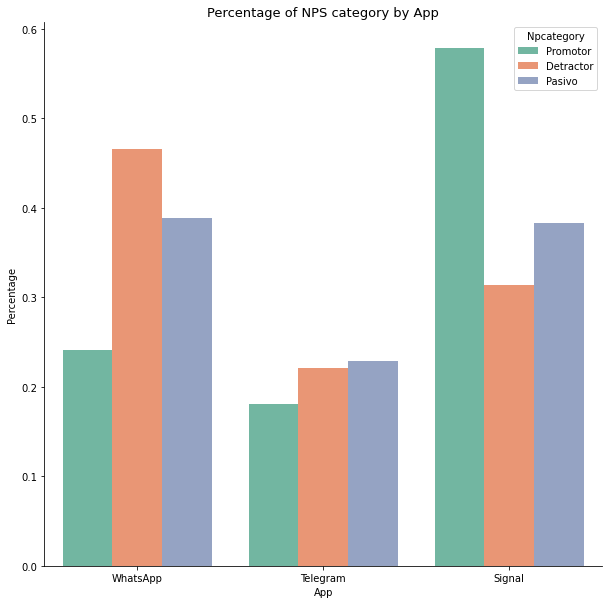

In [141]:
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = NPCategoriesResults.melt(id_vars='npcategory').rename(columns=str.title)
ax = sns.barplot(
    x='Variable', y='Value', hue='Npcategory', 
    data=tidy, ax=ax1, palette='Set2'
)
ax.set_ylabel("Percentage")
ax.set_xlabel("App")
ax.set_title("Percentage of NPS category by App", 
             fontsize=13)
sns.despine(fig)

In [142]:
#creating a pandas object with information based on timeframework

#pre_politica
NPCategoriesResultsPrepolitica = pd.concat(
    [
        df_wsp_new.query("Etapa=='pre_politica'").npcategory.value_counts(),
        df_tlg_new.query("Etapa=='pre_politica'").npcategory.value_counts(),
        df_sgl_new.query("Etapa=='pre_politica'").npcategory.value_counts()
    ], axis=1
)
NPCategoriesResultsPrepolitica = NPCategoriesResultsPrepolitica.reset_index()
NPCategoriesResultsPrepolitica.columns = ["npcategory", "WhatsApp", "Telegram", "Signal"]

#in_politica
NPCategoriesResultsInpolitica = pd.concat(
    [
        df_wsp_new.query("Etapa=='in_politica'").npcategory.value_counts(),
        df_tlg_new.query("Etapa=='in_politica'").npcategory.value_counts(),
        df_sgl_new.query("Etapa=='in_politica'").npcategory.value_counts()
    ], axis=1
)
NPCategoriesResultsInpolitica = NPCategoriesResultsInpolitica.reset_index()
NPCategoriesResultsInpolitica.columns = ["npcategory", "WhatsApp", "Telegram", "Signal"]

#post_politica
NPCategoriesResultsPostpolitica = pd.concat(
    [
        df_wsp_new.query("Etapa=='post_politica'").npcategory.value_counts(),
        df_tlg_new.query("Etapa=='post_politica'").npcategory.value_counts(),
        df_sgl_new.query("Etapa=='post_politica'").npcategory.value_counts()
    ], axis=1
)
NPCategoriesResultsPostpolitica = NPCategoriesResultsPostpolitica.reset_index()
NPCategoriesResultsPostpolitica.columns = ["npcategory", "WhatsApp", "Telegram", "Signal"]

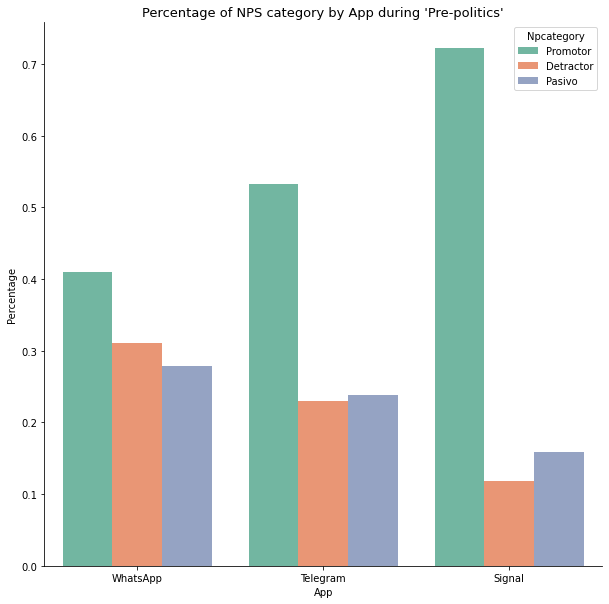

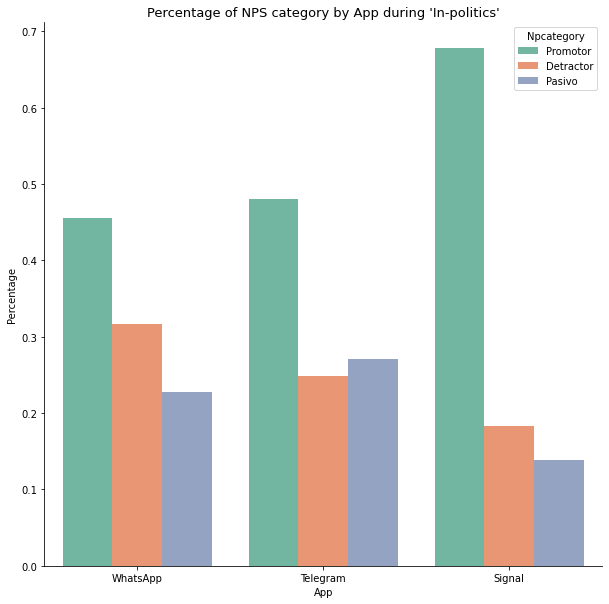

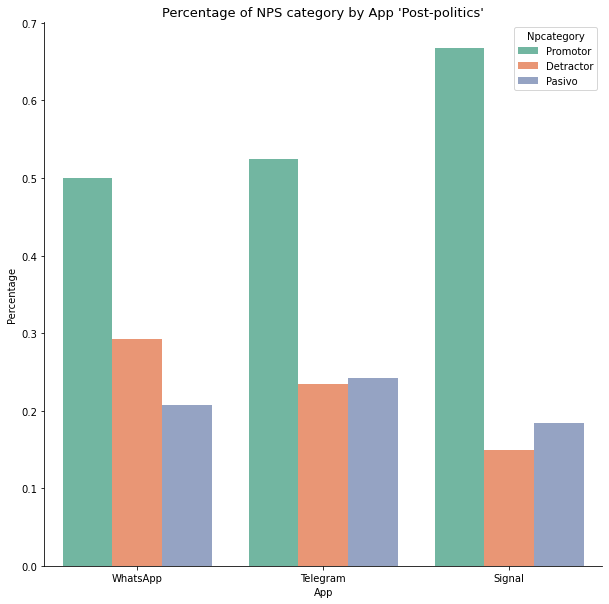

In [143]:
#transforming count information into percentage |Pre politica
NPCategoriesResultsPrepolitica[["WhatsApp", "Telegram", "Signal"]] = NPCategoriesResultsPrepolitica[
    ["WhatsApp", "Telegram", "Signal"]
].apply(lambda x: x / x.sum())

df = pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
})

tidy = NPCategoriesResultsPrepolitica.melt(id_vars='npcategory').rename(columns=str.title)

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = NPCategoriesResultsPrepolitica.melt(id_vars='npcategory').rename(columns=str.title)
ax = sns.barplot(
    x='Variable', y='Value', hue='Npcategory', 
    data=tidy, ax=ax1, palette='Set2'
)
ax.set_ylabel("Percentage")
ax.set_xlabel("App")
ax.set_title("Percentage of NPS category by App during 'Pre-politics'", 
             fontsize=13)
sns.despine(fig)
plt.show()


#transforming count information into percentage |In politica
NPCategoriesResultsInpolitica[["WhatsApp", "Telegram", "Signal"]] = NPCategoriesResultsInpolitica[
    ["WhatsApp", "Telegram", "Signal"]
].apply(lambda x: x / x.sum())

df = pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
})

tidy = NPCategoriesResultsInpolitica.melt(id_vars='npcategory').rename(columns=str.title)

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = NPCategoriesResultsInpolitica.melt(id_vars='npcategory').rename(columns=str.title)
ax = sns.barplot(
    x='Variable', y='Value', hue='Npcategory', 
    data=tidy, ax=ax1, palette='Set2'
)
ax.set_ylabel("Percentage")
ax.set_xlabel("App")
ax.set_title("Percentage of NPS category by App during 'In-politics'", 
             fontsize=13)
sns.despine(fig)
plt.show()


#transforming count information into percentage |In politica
NPCategoriesResultsPostpolitica[["WhatsApp", "Telegram", "Signal"]] = NPCategoriesResultsPostpolitica[
    ["WhatsApp", "Telegram", "Signal"]
].apply(lambda x: x / x.sum())

df = pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
})

tidy = NPCategoriesResultsPostpolitica.melt(id_vars='npcategory').rename(columns=str.title)

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = NPCategoriesResultsPostpolitica.melt(id_vars='npcategory').rename(columns=str.title)
ax = sns.barplot(
    x='Variable', y='Value', hue='Npcategory', 
    data=tidy, ax=ax1, palette='Set2'
)
ax.set_ylabel("Percentage")
ax.set_xlabel("App")
ax.set_title("Percentage of NPS category by App 'Post-politics'", 
             fontsize=13)
sns.despine(fig)
plt.show()

In [197]:
#function to calculate the NPS over time
def seriesNpCategory(pandas):
    _ = pandas.reset_index(drop=True)
    _ = _.npcategory
    timeNPS = []
    for idx in _.index:
        selected = _.loc[:idx]
        temp = selected.value_counts()
        
        if 'Promotor' not in temp.index:
            promotor = 0
            detractor = temp.loc["Detractor"]
        elif 'Detractor' not in temp.index:
            detractor = 0
            promotor = temp.loc["Promotor"]
        else:
            detractor = temp.loc["Detractor"]
            promotor = temp.loc["Promotor"]
        
        #nps calculation
        timeNPS.append((detractor - promotor)/selected.shape[0])
    return timeNPS

In [198]:
def npsScore(frame, etapa):
    grouping = frame.groupby("Etapa").npcategory
    selection = grouping.value_counts()
    series = selection.loc[etapa]
    if 'Promotor' not in series.index:
        promotor = 0
        detractor = series.loc["Detractor"]
    elif 'Detractor' not in series.index:
        detractor = 0
        promotor = series.loc["Promotor"]
    else:
        detractor = series.loc["Detractor"]
        promotor = series.loc["Promotor"]
        
        #nps calculation
    return (promotor - detractor)/series.sum()

In [204]:
#adding NPS values over time
df_wsp_new["NPS"] = seriesNpCategory(df_wsp_new)
df_tlg_new["NPS"] = seriesNpCategory(df_tlg_new)
df_sgl_new["NPS"] = seriesNpCategory(df_sgl_new)

In [205]:
#redefining pandas
df_wsp_new = df_wsp_new.reset_index(drop=True)
df_tlg_new = df_tlg_new.reset_index(drop=True)
df_sgl_new = df_sgl_new.reset_index(drop=True)

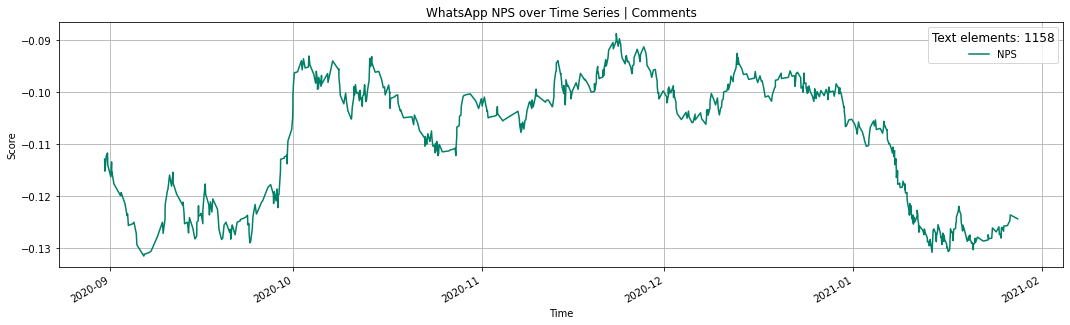

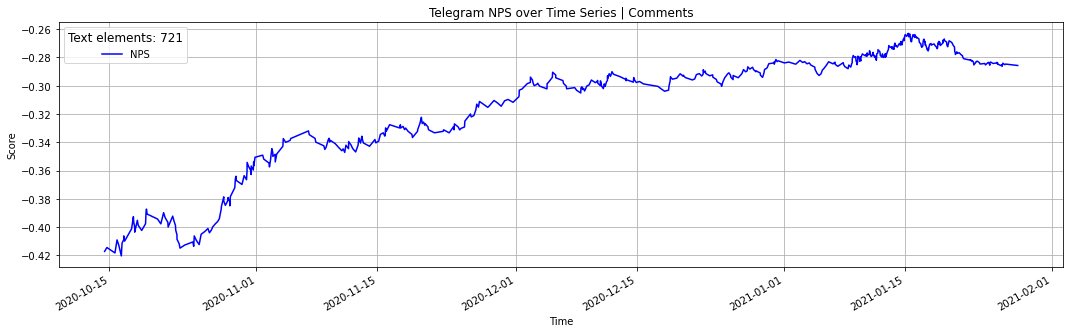

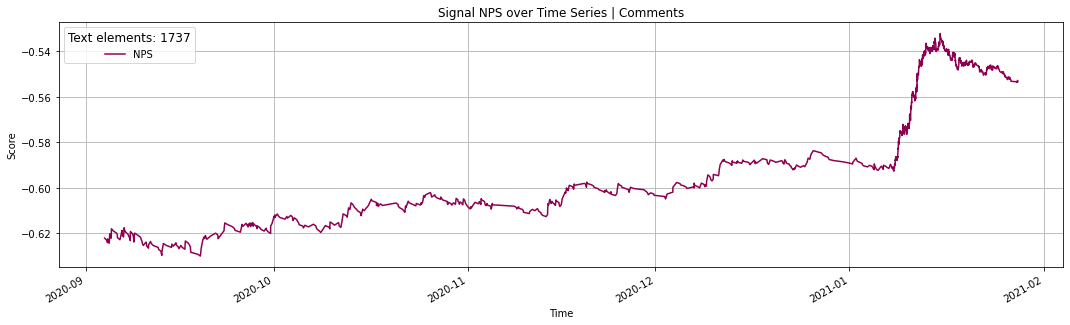

In [206]:
#plot polarity of comments
df_wsp_new.query("NPS!=1 & NPS!=0")[["NPS", "created"]].loc[380:].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='summer', 
).set(xlabel="Time", ylabel="Score", 
      title='WhatsApp NPS over Time Series | Comments',
     )
plt.legend().set_title(
    title=f"Text elements: {df_wsp.shape[0]}", prop = {'size':'large'}
)
plt.show()

df_tlg_new.query("NPS!=1 & NPS!=0")[["NPS", "created"]].loc[150:].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='winter'
).set(xlabel="Time", ylabel="Score", 
      title='Telegram NPS over Time Series | Comments', 
     )
plt.legend().set_title(
    title=f"Text elements: {df_tlg.shape[0]}", prop={'size':'large'}
)
plt.show()

df_sgl_new.query("NPS!=1 & NPS!=0")[["NPS", "created"]].loc[380:].set_index('created').plot(
    figsize=(18,5), grid=True, colormap='PiYG'
).set(xlabel="Time", ylabel="Score",
     title='Signal NPS over Time Series | Comments',
     )
plt.legend().set_title(
    title=f"Text elements: {df_sgl.shape[0]}", prop={'size':'large'}
)
plt.show()

In [207]:
#segmented NPS by timeframework
wspNPS_prepolitica = npsScore(df_wsp_new, "pre_politica")
wspNPS_inpolitica = npsScore(df_wsp_new, "in_politica")
wspNPS_postpolitica = npsScore(df_wsp_new, "post_politica")

tlgNPS_prepolitica = npsScore(df_tlg_new, "pre_politica")
tlgNPS_inpolitica = npsScore(df_tlg_new, "in_politica")
tlgNPS_postpolitica = npsScore(df_tlg_new, "post_politica")

sglNPS_prepolitica = npsScore(df_sgl_new, "pre_politica")
sglNPS_inpolitica = npsScore(df_sgl_new, "in_politica")
sglNPS_postpolitica = npsScore(df_sgl_new, "post_politica")

print("NPS por Horizonte Temporal: ")
print("--"*20)
print("WhatsApp:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {wspNPS_prepolitica}")
print(f"- Etapa 'In Políticas'   | Total: {wspNPS_inpolitica}")
print(f"- Etapa 'Post Políticas' | Total: {wspNPS_postpolitica}\n")
print("Telegram:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {tlgNPS_prepolitica}")
print(f"- Etapa 'In Políticas'   | Total: {tlgNPS_inpolitica}")
print(f"- Etapa 'Post Políticas' | Total: {tlgNPS_postpolitica}\n")
print("Signal:\n")
print(f"- Etapa 'Pre Políticas'  | Total: {sglNPS_prepolitica}")
print(f"- Etapa 'In Políticas'   | Total: {sglNPS_inpolitica}")
print(f"- Etapa 'Post Políticas' | Total: {sglNPS_postpolitica}\n")

NPS por Horizonte Temporal: 
----------------------------------------
WhatsApp:

- Etapa 'Pre Políticas'  | Total: 0.09898477157360407
- Etapa 'In Políticas'   | Total: 0.13924050632911392
- Etapa 'Post Políticas' | Total: 0.20754716981132076

Telegram:

- Etapa 'Pre Políticas'  | Total: 0.3023255813953488
- Etapa 'In Políticas'   | Total: 0.23255813953488372
- Etapa 'Post Políticas' | Total: 0.2903225806451613

Signal:

- Etapa 'Pre Políticas'  | Total: 0.6032388663967612
- Etapa 'In Políticas'   | Total: 0.4956521739130435
- Etapa 'Post Políticas' | Total: 0.5187287173666288



In [208]:
#global NPS by app

whatsappNPS = (
    df_wsp_new.npcategory.value_counts()["Promotor"] - df_wsp_new.npcategory.value_counts()["Detractor"]
)/df_wsp_new.shape[0]

telegramNPS = (
    df_tlg_new.npcategory.value_counts()["Promotor"] - df_tlg_new.npcategory.value_counts()["Detractor"]
)/df_tlg_new.shape[0]

signalNPS = (
    df_sgl_new.npcategory.value_counts()["Promotor"] - df_sgl_new.npcategory.value_counts()["Detractor"]
)/df_sgl_new.shape[0]

print(f"WhatsApp NPS:{whatsappNPS}")
print(f"Telegram NPS:{telegramNPS}")
print(f"Signal NPS  :{signalNPS}")

WhatsApp NPS:0.12435233160621761
Telegram NPS:0.2857142857142857
Signal NPS  :0.5532527345998849


### Palabras por app

In [189]:
fd_wsp_bd = FreqDist(word_tokenize(' '.join(df_wsp["body"])))
fd_tlg_bd = FreqDist(word_tokenize(' '.join(df_tlg["body"])))
fd_sgl_bd = FreqDist(word_tokenize(' '.join(df_sgl["body"])))

fd_wsp_cm = FreqDist(word_tokenize(' '.join(df_wsp["comments"])))
fd_tlg_cm = FreqDist(word_tokenize(' '.join(df_tlg["comments"])))
fd_sgl_cm = FreqDist(word_tokenize(' '.join(df_sgl["comments"])))

Whatsapp

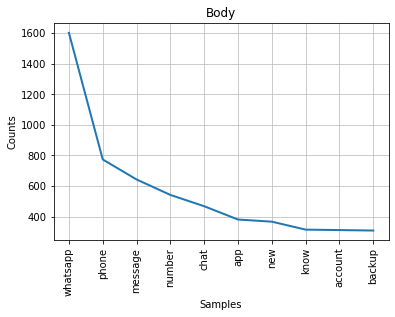

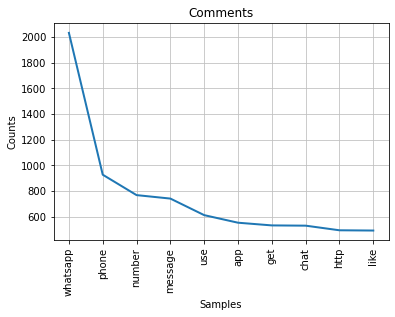

In [163]:
fd_wsp_bd.plot(10, title = "Body") 
fd_wsp_cm.plot(10, title = "Comments") 

Telegram

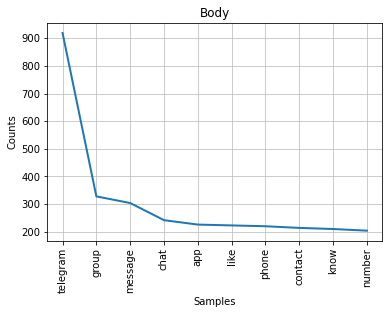

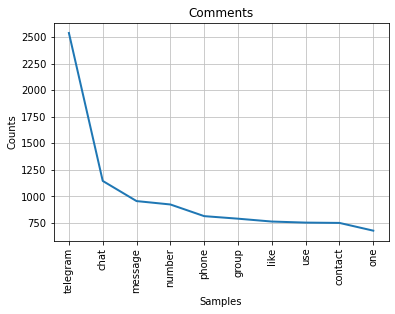

In [153]:
fd_tlg_bd.plot(10, title = "Body") 
fd_tlg_cm.plot(10, title = "Comments") 

Signal

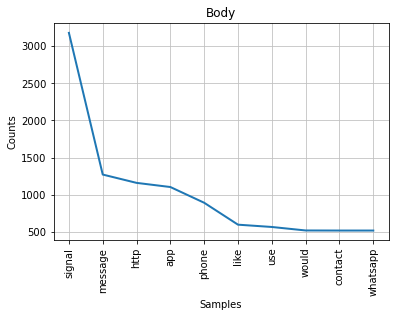

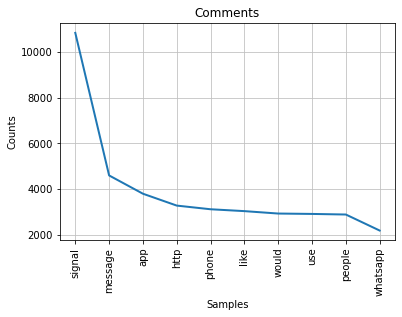

In [154]:
fd_sgl_bd.plot(10, title = "Body") 
fd_sgl_cm.plot(10, title = "Comments") 